In [1]:
!pip install pyspark
!apt-get update
! apt install -y openjdk-11-jre-headless
#! apt install -y openjdk-11-jdk openjdk-8-jre

     |████████████████████████████████| 212.3 MB 13 kB/s s eta 0:00:01    |████                            | 27.1 MB 13.9 MB/s eta 0:00:14     |███████▍                        | 49.2 MB 29.9 MB/s eta 0:00:06     |████████████████████▌           | 135.7 MB 37.0 MB/s eta 0:00:03
     |████████████████████████████████| 198 kB 33.2 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=701bfc01da4a0ce417ddf94e5c0fd7286d5fb37e23b9f2cdbf406dfa3c781149
  Stored in directory: /root/.cache/pip/wheels/43/47/42/bc413c760cf9d3f7b46ab7cd6590e8c47ebfd19a7386cd4a57
Successfully built pyspark
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5394 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:5 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6

In [2]:
!java -version

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [3]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

sc= SparkContext(master= 'local', appName= 'Fake and real news(2)')
ss= SparkSession(sc)

In [4]:
from pyspark.sql.types import StringType, StructField, StructType
def read_data(path):
  schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])
  pd_df= pd.read_csv(path)
  sp_df= ss.createDataFrame(pd_df, schema= schema)
  return sp_df

In [5]:
path_true= '/kaggle/input/fake-and-real-news-dataset/True.csv'
path_fake= '/kaggle/input/fake-and-real-news-dataset/Fake.csv'
true_df= read_data(path_true)
fake_df= read_data(path_fake)

In [6]:
true_df.count()

21417

In [7]:
fake_df.count()

23481

In [8]:
from pyspark.sql.functions import lit, rand
data= true_df.withColumn('fake', lit(0)).union(fake_df.withColumn('fake', lit(1))).orderBy(rand())

In [9]:
data.groupBy('fake').count().show()

+----+-----+
|fake|count|
+----+-----+
|   1|23481|
|   0|21417|
+----+-----+



In [10]:
data.select('subject').distinct().show()

+---------------+
|        subject|
+---------------+
|        US_News|
|      left-news|
|      worldnews|
|       politics|
|   politicsNews|
|Government News|
|    Middle-east|
|           News|
+---------------+



In [11]:
data.show(10)

+--------------------+--------------------+------------+-------------------+----+
|               title|                text|     subject|               date|fake|
+--------------------+--------------------+------------+-------------------+----+
|Judges rule Trump...|NEW YORK (Reuters...|politicsNews|      May 17, 2016 |   0|
|Homeland Security...|(Reuters) - Donal...|politicsNews|  November 8, 2017 |   0|
|Trump's team seek...|WASHINGTON (Reute...|politicsNews| November 14, 2016 |   0|
|Angry over U.S. h...| NEW PORT RICHEY,...|politicsNews|    March 26, 2017 |   0|
|Brexit deal on Ir...|BRUSSELS (Reuters...|   worldnews|  December 7, 2017 |   0|
|LIBERTARIAN Gary ...|Johnson calls Oba...|    politics|        Aug 8, 2016|   1|
|U.S. House passes...|WASHINGTON (Reute...|politicsNews|September 14, 2017 |   0|
|[VIDEO] Hillary C...|Hillary, the firs...|    politics|       Oct 17, 2015|   1|
| Exposed: These R...|Republicans in Co...|        News|   February 4, 2016|   1|
|North Carolina 

In [12]:
from pyspark.ml.feature import SQLTransformer, RegexTokenizer, StopWordsRemover, CountVectorizer, Imputer, IDF
from pyspark.ml.feature import StringIndexer, VectorAssembler
StopWordsRemover.loadDefaultStopWords('english')

# 0. Extract tokens from title
title_tokenizer= RegexTokenizer(inputCol= 'title', outputCol= 'title_words',
                                pattern= '\\W', toLowercase= True)
# 1. Remove stop words from title
title_sw_remover= StopWordsRemover(inputCol= 'title_words', outputCol= 'title_sw_removed')
# 2. Compute Term frequency from title
title_count_vectorizer= CountVectorizer(inputCol= 'title_sw_removed', outputCol= 'tf_title')
# 3. Compute Term frequency-inverse document frequency from title
title_tfidf= IDF(inputCol= 'tf_title', outputCol= 'tf_idf_title')
# 4. Extract tokens from text
text_tokenizer= RegexTokenizer(inputCol= 'text', outputCol= 'text_words',
                                pattern= '\\W', toLowercase= True)
# 5. Remove stop words from text
text_sw_remover= StopWordsRemover(inputCol= 'text_words', outputCol= 'text_sw_removed')
# 6. Compute Term frequency from text
text_count_vectorizer= CountVectorizer(inputCol= 'text_sw_removed', outputCol= 'tf_text')
# 7. Compute Term frequency-inverse document frequency text
text_tfidf= IDF(inputCol= 'tf_text', outputCol= 'tf_idf_text')
# 8. StringIndexer subject
subject_str_indexer= StringIndexer(inputCol= 'subject', outputCol= 'subject_idx')
# 9. VectorAssembler
vec_assembler= VectorAssembler(inputCols=['tf_idf_title', 'tf_idf_text', 'subject_idx'], outputCol= 'features')

In [13]:
from pyspark.ml.classification import LinearSVC


rf = LinearSVC(featuresCol= 'features', labelCol= 'fake', predictionCol= 'fake_predict', maxIter=30, regParam=0.3)

In [14]:
from pyspark.ml import Pipeline
rf_pipe= Pipeline(stages=[title_tokenizer, # 0
                title_sw_remover, # 1
                title_count_vectorizer, # 2
                title_tfidf, # 3
                text_tokenizer, # 4
                text_sw_remover, # 5
                text_count_vectorizer, # 6
                text_tfidf, # 7
                subject_str_indexer, # 8
                vec_assembler, # 9
                rf]) # 10 model

In [15]:
train, test= data.randomSplit([0.8, 0.2])

In [16]:
rf_model= rf_pipe.fit(train)

In [17]:
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator

accuracy= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'accuracy')
f1= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'f1')
areaUnderROC= BinaryClassificationEvaluator(labelCol= 'fake', metricName= 'areaUnderROC')

def classification_evaluator(data_result):
    data_result.crosstab(col1= 'fake_predict', col2= 'fake').show()
    print('accuracy:' ,accuracy.evaluate(data_result))
    print('f1:' ,f1.evaluate(data_result))
    print('areaUnderROC:' ,areaUnderROC.evaluate(data_result))

In [18]:
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator

accuracy= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'accuracy')
f1= MulticlassClassificationEvaluator(labelCol= 'fake', predictionCol= 'fake_predict', metricName= 'f1')
areaUnderROC= BinaryClassificationEvaluator(labelCol= 'fake', metricName= 'areaUnderROC')

def classification_evaluator(data_result):
    data_result.crosstab(col1= 'fake_predict', col2= 'fake').show()
    print('accuracy:' ,accuracy.evaluate(data_result))
    print('f1:' ,f1.evaluate(data_result))
    print('areaUnderROC:' ,areaUnderROC.evaluate(data_result))

In [19]:
rf_train_result= rf_model.transform(train)

In [20]:
classification_evaluator(rf_train_result)

+-----------------+-----+-----+
|fake_predict_fake|    0|    1|
+-----------------+-----+-----+
|              1.0|    0|18698|
|              0.0|17213|    0|
+-----------------+-----+-----+

accuracy: 1.0
f1: 1.0
areaUnderROC: 0.9999998073628851


In [21]:
rf_test_result= rf_model.transform(test)

In [22]:
classification_evaluator(rf_test_result)

+-----------------+----+----+
|fake_predict_fake|   0|   1|
+-----------------+----+----+
|              1.0|  18|4743|
|              0.0|4186|  40|
+-----------------+----+----+

accuracy: 0.9935462334483143
f1: 0.9935472164021519
areaUnderROC: 0.9994279563702216


In [23]:
lrModel = rf_model.stages[10]
trainingSummary = lrModel.summary

In [24]:
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

AttributeError: 'function' object has no attribute 'roc'

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


predictions_train = rf_model.transform(train)

y_true = predictions_train.select(['fake']).collect()
y_pred = predictions_train.select(['fake_predict']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, output_dict=True))

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17213}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 18698}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35911}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35911}}


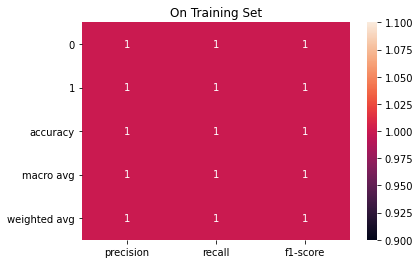

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).iloc[:-1, :].T,ax = ax, annot=True)
ax.set_title('On Training Set')
plt.show()

In [28]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


predictions_test = rf_model.transform(test)

y_true = predictions_test.select(['fake']).collect()
y_pred = predictions_test.select(['fake_predict']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, output_dict=True))

{'0': {'precision': 0.9905347846663511, 'recall': 0.9957183634633682, 'f1-score': 0.9931198102016607, 'support': 4204}, '1': {'precision': 0.996219281663516, 'recall': 0.9916370478779009, 'f1-score': 0.9939228834870075, 'support': 4783}, 'accuracy': 0.9935462334483143, 'macro avg': {'precision': 0.9933770331649336, 'recall': 0.9936777056706345, 'f1-score': 0.9935213468443341, 'support': 8987}, 'weighted avg': {'precision': 0.9935601489856388, 'recall': 0.9935462334483143, 'f1-score': 0.9935472164021519, 'support': 8987}}


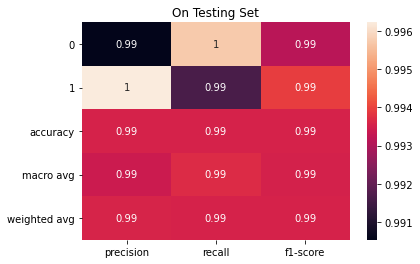

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).iloc[:-1, :].T,ax = ax, annot=True)
ax.set_title('On Testing Set')
plt.show()

In [30]:
class_temp = rf_test_result.select("fake").groupBy("fake")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["fake"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

In [31]:
from sklearn.metrics import confusion_matrix
y_true = rf_test_result.select("fake")
y_true = y_true.toPandas()

y_pred = rf_test_result.select("fake_predict")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[4186,   18],
       [  40, 4743]])

Confusion matrix, without normalization
[[4186   18]
 [  40 4743]]


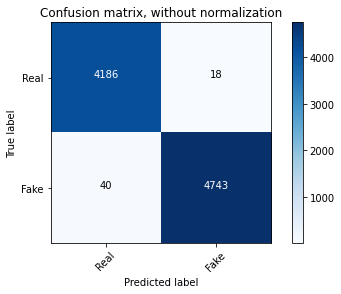

In [32]:
import matplotlib.pyplot as plt
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Real', 'Fake'],
                      title='Confusion matrix, without normalization')
plt.show()